In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.stats
import h5py
import os

from cca.kron_pca import form_lag_matrix, toeplitzify
from cca.cov_util import calc_cross_cov_mats_from_cov
from cca.synth_data import gen_lorenz_system
from cca import ComplexityComponentsAnalysis

RESULTS_FILENAME = "lorenz_results_N50.hdf5"

In [12]:
def gen_noise_cov(N, D, var, noise_V=None):
    noise_spectrum = var*np.exp(-2*np.arange(N)/D)
    if noise_V is None:
        noise_V = scipy.stats.ortho_group.rvs(N)
    noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))
    return noise_cov

def random_basis(N, D):
    return scipy.stats.ortho_group.rvs(N)[:, :D]

def plot_3d(X, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    ax.plot(X[:, 0], X[:, 1], X[:, 2], c="black")

In [16]:
#Set this to False for safety
delete_old_file = False

#Set parameters
T = 10
N = 50
noise_dim = 3
snr_vals = np.logspace(-2, 2, 10)
noise_orientations_per_snr = 10

#Save params
if delete_old_file:
    try:
        os.remove(RESULTS_FILENAME)
    except OSError:
        pass
f = h5py.File(RESULTS_FILENAME, "w-")
f.attrs["T"] = T
f.attrs["N"] = N
f.attrs["noise_dim"] = noise_dim
f.attrs["snr_vals"] = snr_vals

#Generate Lorenz dynamics
num_samples = 10000
integration_dt = 0.005
data_dt = 0.025
X_dynamics = gen_lorenz_system((num_samples + 1000)*data_dt, integration_dt, data_dt)[1000:]
X_dynamics = (X_dynamics - X_dynamics.mean(axis=0))/X_dynamics.std(axis=0)
dynamics_var = np.max(scipy.linalg.eigvalsh(np.cov(X_dynamics.T)))

#Save dynamics
f.create_dataset("X_dynamics", data=X_dynamics)
f.attrs["dynamics_var"] = dynamics_var

#Generate dynamics embedding matrix (will remain fixed)
np.random.seed(42)
V = random_basis(N, 3)
X = np.dot(X_dynamics, V.T)

#Save embeded dynamics
f.create_dataset("X", data=X)

#To-save: noisy data, reconstructed PCA, reconstructed DCA
X_noisy_dset = f.create_dataset("X_noisy", (len(snr_vals), noise_orientations_per_snr, num_samples, N))
X_pca_trans_dset = f.create_dataset("X_pca_trans", (len(snr_vals), noise_orientations_per_snr, num_samples, 3))
X_dca_trans_dset = f.create_dataset("X_dca_trans", (len(snr_vals), noise_orientations_per_snr, num_samples, 3))

#Loop over SNR vals
for snr_idx in range(len(snr_vals)):
    snr = snr_vals[snr_idx]
    print("snr =", snr)
    noise_var = dynamics_var/snr
    
    #Loop over noise random noise orientations
    for orientation_idx in range(noise_orientations_per_snr):
        print("orientation_idx =", orientation_idx)
        
        #Generate+save noise covariacne
        noise_cov = gen_noise_cov(N, noise_dim, noise_var)
        
        #Form noisy data
        X_noisy = X + np.random.multivariate_normal(mean=np.zeros(N), cov=noise_cov, size=num_samples)
        X_noisy = X_noisy - X_noisy.mean(axis=0)
        
        #Save noisy data
        X_noisy_dset[snr_idx, orientation_idx] = X_noisy
        
        #Compute PSD+Toeplitz spatiotemporal covariance
        X_lags = form_lag_matrix(X_noisy, T)
        cov = np.dot(X_lags.T, X_lags)/len(X_lags)
        cov_toep = toeplitzify(cov, N, T)
        min_eig = np.min(np.linalg.eigvalsh(cov_toep))
        if min_eig < 0:
            cov_toep += (-min_eig + 1e-4)*np.eye(cov_toep.shape[0])
        cross_cov_mats = calc_cross_cov_mats_from_cov(N, T, cov_toep)
        
        #Run DCA
        opt = ComplexityComponentsAnalysis(init="random_ortho")
        opt.cross_covs = cross_cov_mats
        opt.fit_projection(d=3)
        V_dca = opt.coef_
        
        #Run PCA
        V_pca = scipy.linalg.eigh(np.cov(X_noisy.T))[1][:, ::-1][:, :3]
        
        #Project data onto DCA and PCA bases
        X_dca = np.dot(X_noisy, V_dca)
        X_pca = np.dot(X_noisy, V_pca)
        
        #Linearly trasnform projected data to be close to original Lorenz attractor
        beta_pca = np.linalg.lstsq(X_pca, X_dynamics, rcond=None)[0]
        beta_dca = np.linalg.lstsq(X_dca, X_dynamics, rcond=None)[0]
        X_pca_trans = np.dot(X_pca, beta_pca)
        X_dca_trans = np.dot(X_dca, beta_dca)
        
        #Save transformed projections
        X_pca_trans_dset[snr_idx, orientation_idx] = X_pca_trans
        X_dca_trans_dset[snr_idx, orientation_idx] = X_dca_trans

snr = 0.01
orientation_idx = 0
orientation_idx = 1
orientation_idx = 2
orientation_idx = 3
orientation_idx = 4
orientation_idx = 5
orientation_idx = 6
orientation_idx = 7
orientation_idx = 8
orientation_idx = 9
snr = 0.027825594022071243
orientation_idx = 0
orientation_idx = 1
orientation_idx = 2
orientation_idx = 3
orientation_idx = 4
orientation_idx = 5
orientation_idx = 6
orientation_idx = 7
orientation_idx = 8
orientation_idx = 9
snr = 0.0774263682681127
orientation_idx = 0
orientation_idx = 1
orientation_idx = 2
orientation_idx = 3
orientation_idx = 4
orientation_idx = 5
orientation_idx = 6
orientation_idx = 7
orientation_idx = 8
orientation_idx = 9
snr = 0.21544346900318834
orientation_idx = 0
orientation_idx = 1
orientation_idx = 2
orientation_idx = 3
orientation_idx = 4
orientation_idx = 5
orientation_idx = 6
orientation_idx = 7
orientation_idx = 8
orientation_idx = 9
snr = 0.5994842503189409
orientation_idx = 0
orientation_idx = 1
orientation_idx = 2
orientation_idx = 3
orient

In [111]:
f = h5py.File(RESULTS_FILENAME, "r")
snr_vals = f.attrs["snr_vals"]
X_noisy_dset = f["X_noisy"]
X_pca_trans_dset = f["X_pca_trans"]
X_dca_trans_dset = f["X_dca_trans"]
num_snr_vals, noise_orientations_per_snr = X_noisy_dset.shape[:2]
X_dynamics = f["X_dynamics"]

r2_vals = np.zeros(( num_snr_vals,  noise_orientations_per_snr, 2))
for snr_idx in range(num_snr_vals):
    for orientation_idx in range(noise_orientations_per_snr):
        X_pca_trans = X_pca_trans_dset[snr_idx, orientation_idx]
        X_dca_trans = X_dca_trans_dset[snr_idx, orientation_idx]
        r2_pca = 1 - np.sum((X_pca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
        r2_dca = 1 - np.sum((X_dca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
        r2_vals[snr_idx, orientation_idx] = [r2_pca, r2_dca]

In [138]:
def make_axes():
    width, height = 10, 2.5
    wpad = -2*0.01
    hpad = -2*0.05
    axwidth = (1 - 5*wpad)/4
    axheight = (1 - 2*hpad)/2
    fig = plt.figure(figsize=(width, height))
    
    ax1 = fig.add_axes((wpad, 2*hpad + axheight, axwidth, axheight), projection='3d')
    ax2 = fig.add_axes((2*wpad + axwidth, 2*hpad + axheight, axwidth, axheight), projection='3d')
    ax3 = fig.add_axes((3*wpad + 2*axwidth, 2*hpad + axheight, axwidth, axheight), projection='3d')
    
    ax4 = fig.add_axes((wpad, hpad, axwidth, axheight), projection='3d')
    ax5 = fig.add_axes((2*wpad + axwidth, hpad, axwidth, axheight), projection='3d')
    ax6 = fig.add_axes((3*wpad + 2*axwidth, hpad, axwidth, axheight), projection='3d')
    
    ax7 = fig.add_axes((4*wpad + 3*axwidth, hpad, axwidth, 2*axheight + hpad))
    
    three_d_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    for ax in three_d_axes:
        ax.set_axis_off() 
        
    return three_d_axes + [ax7]

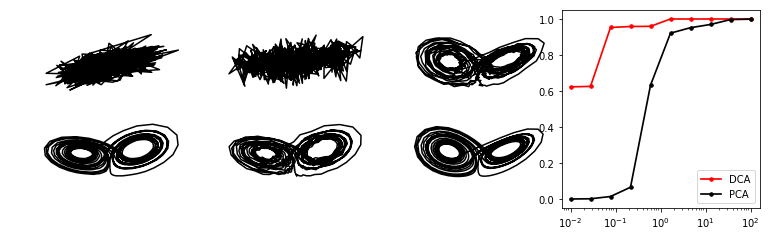

In [146]:
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = make_axes()

plot_3d(X_pca_trans_dset[2, 1, :1000], ax1)
plot_3d(X_dca_trans_dset[2, 1, :1000], ax4)

plot_3d(X_pca_trans_dset[4, 0, :1000], ax2)
plot_3d(X_dca_trans_dset[4, 0, :1000], ax5)

plot_3d(X_pca_trans_dset[8, 0, :1000], ax3)
plot_3d(X_dca_trans_dset[8, 0, :1000], ax6)


ax7.plot(snr_vals, np.median(r2_vals, axis=1)[:, 1], label="DCA", linewidth=1.7, markersize=7, marker=".", c="red", zorder=0)
ax7.plot(snr_vals, np.median(r2_vals, axis=1)[:, 0], label="PCA", linewidth=1.7, markersize=7, marker=".", c="black", zorder=1)
ax7.set_xscale("log")
ax7.legend()

plt.show()
